In [ ]:
!pip install git+https://github.com/aimclub/eXplain-NNs &> /dev/null
!wget https://raw.githubusercontent.com/aimclub/eXplain-NNs/main/requirements.txt
!pip install -r requirements.txt
!pip install torchmetrics &> /dev/null

--2024-01-08 12:57:12--  https://raw.githubusercontent.com/aimclub/eXplain-NNs/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1486 (1.5K) [text/plain]
Saving to: ‘requirements.txt.2’

requirements.txt.2  100%[===================>]   1.45K  --.-KB/s    in 0s      

2024-01-08 12:57:12 (21.8 MB/s) - ‘requirements.txt.2’ saved [1486/1486]



In [ ]:
from google.colab import output

!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip EuroSAT.zip

output.clear()

In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torchvision.transforms as TF

from random import shuffle
import time
import warnings

from eXNN.visualization import visualize_layer_manifolds

2024-01-08 12:57:37.461498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 12:57:37.461541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 12:57:37.462994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 12:57:37.471127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 12:57:39.234463: W tensorflow/comp

In [ ]:
# prepare data
warnings.filterwarnings('ignore')

path_to_data = '2750'

dataset = ImageFolder(
    path_to_data,
    transform = TF.Compose([
        TF.Resize((64, 64)),
        TF.ToTensor()
    ])
)

n_obj = 3000
cls_indicies = [(i, obj) for i, obj in enumerate(dataset.targets)]
shuffle(cls_indicies)

cls_indicies = cls_indicies[0:n_obj]

num_classes = len(dataset.classes)

classes_names = dataset.classes

train_ds = torch.utils.data.Subset(dataset, indices = [i[0] for i in cls_indicies[0:int(len(cls_indicies)*0.6)]])
test_ds = torch.utils.data.Subset(dataset, indices = [i[0] for i in cls_indicies[int(len(cls_indicies)*0.6):]])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=36, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=36, shuffle=False)

In [ ]:
# train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Training on {device}')
model = resnet18(num_classes=num_classes).to(device)
model = model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay = 0.0001)#, momentum=0.9)
criterion = nn.CrossEntropyLoss()
n_epochs = 20
for epoch in range(n_epochs):
  time_mark = time.time()
  running_loss = 0
  for images, labels in train_dl:
    optimizer.zero_grad()
    loss = criterion(model(images.to(device)), labels.to(device))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print("Epoch {} - Training loss: {} - Time taken: {} sec".format(epoch, running_loss/len(train_dl), round(time.time() - time_mark, 2)))
model = model.eval()

Training on cuda
Epoch 0 - Training loss: 2.022846620082855 - Time taken: 3.86 sec
Epoch 1 - Training loss: 1.5791466522216797 - Time taken: 2.29 sec
Epoch 2 - Training loss: 1.3448776984214783 - Time taken: 2.25 sec
Epoch 3 - Training loss: 1.1976719200611115 - Time taken: 2.34 sec
Epoch 4 - Training loss: 1.044014366865158 - Time taken: 2.58 sec
Epoch 5 - Training loss: 0.9292078137397766 - Time taken: 2.25 sec
Epoch 6 - Training loss: 0.8611904096603393 - Time taken: 2.22 sec
Epoch 7 - Training loss: 0.7472303003072739 - Time taken: 2.25 sec
Epoch 8 - Training loss: 0.6546678161621093 - Time taken: 2.26 sec
Epoch 9 - Training loss: 0.6093837463855744 - Time taken: 2.52 sec
Epoch 10 - Training loss: 0.5764208489656448 - Time taken: 2.53 sec
Epoch 11 - Training loss: 0.4660166943073273 - Time taken: 2.25 sec
Epoch 12 - Training loss: 0.40863604068756104 - Time taken: 2.31 sec
Epoch 13 - Training loss: 0.36586644560098647 - Time taken: 2.29 sec
Epoch 14 - Training loss: 0.3427524486184

In [ ]:
# collect test data for visualization
data, labels = [], []
itr = iter(test_dl)
for i in range(10):
    batch = next(itr)
    data.append(batch[0])
    labels.append(batch[1])
data = torch.cat(data, dim=0)
labels = torch.cat(labels, dim=0)

In [ ]:
# visualize
model = model.eval()
layers = ['layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
res = visualize_layer_manifolds(model, 'umap', data.to(device), layers, labels=labels, chunk_size=128)

Let's look at how well the trained model separated classes

Input data is not split at all

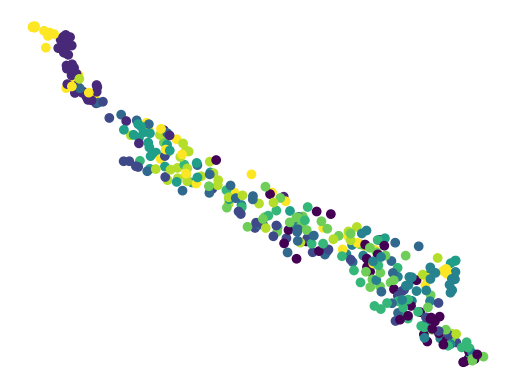

In [ ]:
res['input']

After half of a network some structure starts to emerge

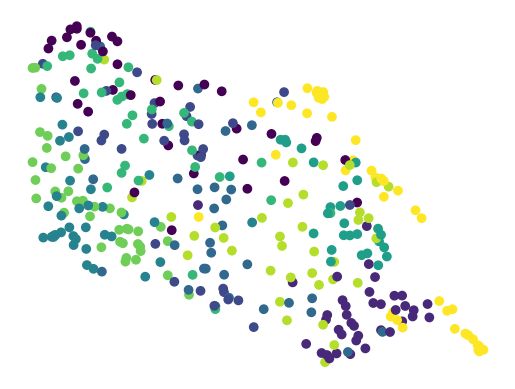

In [ ]:
res['layer3']

Finally, after the last layer classes are well split

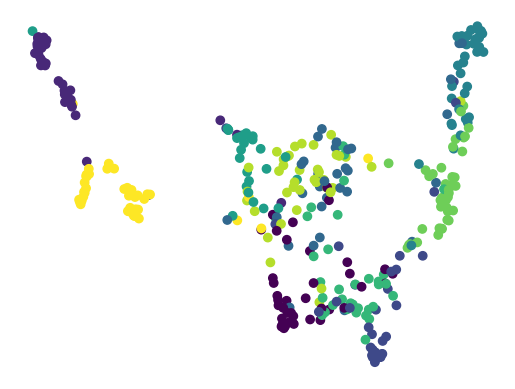

In [ ]:
res['fc']